# Training Rat Detector on YOLOv10 using Transfer Learning

Adapted from: https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov10-object-detection-on-custom-dataset.ipynb

In [ ]:
!nvidia-smi

Tue Jun 25 18:24:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.7 MB/s eta 0:00:00


In [ ]:
!pip install -q supervision roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Download different model sizes (n smallest - x largrest)
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

#!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('RoboKey')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace().project("rat-detector-gdm1a")
version = project.version(1)
dataset = version.download("yolov9")  #use yolov9 format for model as format for yolov10 wasn't available

# edit data.yaml file so it has correct folder structure
# (sed is a unix utility for editing file programmatically)
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rat-detector-1 in yolov9:: 100%|██████████| 892/892 [00:00<00:00, 4785.72it/s]


In [ ]:
dataset.location
!ls -lh {dataset.location}

total 16K
-rw-r--r-- 1 root root  222 Jun 25 18:26 data.yaml
-rw-r--r-- 1 root root  984 Jun 25 18:26 README.roboflow.txt
drwxr-xr-x 4 root root 4.0K Jun 25 18:26 train
drwxr-xr-x 4 root root 4.0K Jun 25 18:26 valid


In [ ]:
%cd {HOME}
# training model with only layers near the output trainable, all other frozen
# freezing layers speeds up training but lowers overall accuracy, best accuracy (mAP) with no layers frozen
# Try training with only the last layer trainable (freeze=23) and last 5 layers (freeze=19) and compare
# Use medium size of model and 250 epochs, batch autoselected and single class option (single_cls=True)
# See:  https://docs.ultralytics.com/modes/train/#train-settings

modelsize='n' # one of 'n','s','m','b','l','x' increasing size, seems to have only limited effect on performance for this dataset
freeze = 19 # number of layers to freeze, 0 no layers frozen, 23 all but last layer, 19 a few of the end-layers frozen
epochs=250

!yolo task=detect mode=train epochs={epochs} batch=-1 plots=True \
single_cls=True freeze={freeze} exist_ok=True \
model={HOME}/weights/yolov10{modelsize}.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.41 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/Rat-detector-1/data.yaml, epochs=250, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=19, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

In [ ]:
from google.colab import drive
# Mount point in Colabs machine
drive.mount('/content/drive')

# Location of project in Google Drive after mounting

def get_fpath():
  if "Colabs" in os.listdir("/content/drive/MyDrive"):
    return '/content/drive/MyDrive/Colabs/Rat_detector'
  else:
    return '/content/drive/MyDrive/Rat_detector'

fpath=get_fpath()
fpath


Mounted at /content/drive


'/content/drive/MyDrive/Rat_detector'

In [ ]:
!mkdir -p {fpath}/dataset_final
!cp -r {dataset.location} {fpath}/dataset_final


In [ ]:

# if running without training and modelsize+freeze not defined
if 'modelsize' in locals():
  rpath=f"{fpath}/train_v10{modelsize}_freeze{freeze}"
else:
  rpath=f"{fpath}/train_v10n_freeze0" # default model

print("rpath:",rpath)

# copy training info to google drive
# uncomment below only if new run is available or to overwrite an older training output!
#!mkdir -p {rpath}
#!cp -r {HOME}/runs/detect/train/* {rpath}
# remove to prevent results being appended
#!rm -r {HOME}/runs/detect/train


rpath: /content/drive/MyDrive/Colabs/Rat_detector/train_v10n_freeze19


### Comparing training speed vs. accuracy for different number of layers frozen

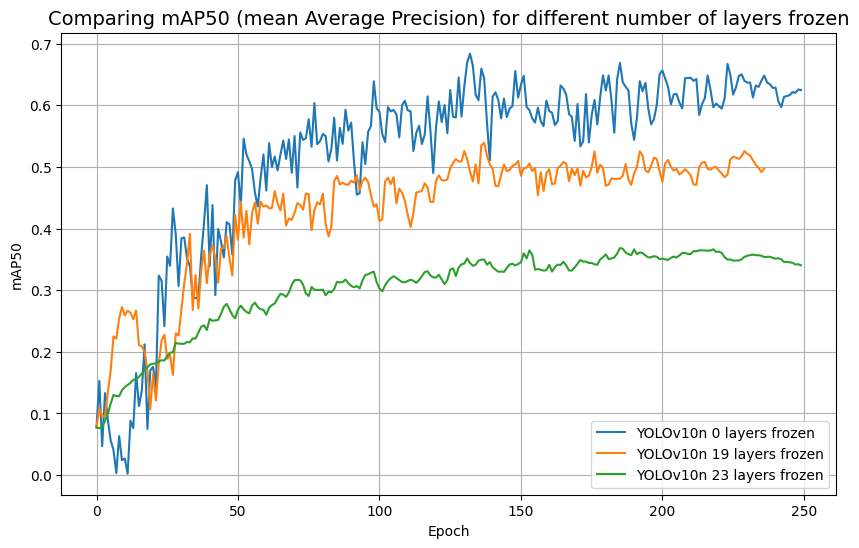

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# load stored training runs for 0,19 and 23 layers frozen
df_n0=pd.read_csv(f'{get_fpath()}/train_v10n_freeze0/results.csv')
df_n19=pd.read_csv(f'{get_fpath()}/train_v10n_freeze19/results.csv')
df_n23=pd.read_csv(f'{get_fpath()}/train_v10n_freeze23/results.csv')
# clean column names
df_n0.columns=df_n0.columns.str.strip()
df_n19.columns=df_n19.columns.str.strip()
df_n23.columns=df_n23.columns.str.strip()

fig,ax=plt.subplots(1,1,figsize=(10,6))

ax.plot(df_n0['metrics/mAP50(B)'],label='YOLOv10n 0 layers frozen')
ax.plot(df_n19['metrics/mAP50(B)'],label='YOLOv10n 19 layers frozen')
ax.plot(df_n23['metrics/mAP50(B)'],label='YOLOv10n 23 layers frozen')
ax.legend(loc='lower right')
ax.set_xlabel('Epoch')
ax.set_ylabel('mAP50')
ax.grid('both')
ax.set_title('Comparing mAP50 (mean Average Precision) for different number of layers frozen',fontsize=14);


### Validating

In [ ]:
# choose from trained models of different size and training strategy (how many layers frozen)
val_modelsize='n' # one of 'n','s','m','b','l','x' increasing size
val_freeze = 0 # number of layers to freeze, 0 no layers frozen, 23 all but last layer, 19 a few of the end-layers frozen

vpath=f"{fpath}/train_v10{val_modelsize}_freeze{val_freeze}"
vpath

'/content/drive/MyDrive/Colabs/Rat_detector/train_v10n_freeze0'

In [ ]:
!cd {HOME}
!yolo detect val model={vpath}/weights/best.pt exist_ok=True data={dataset.location}/data.yaml
#!!yolo detect val model=/content/drive/MyDrive/Rat_detector/train_v10n_freeze0/weights/best.pt exist_ok=True data=/content/datasets/Rat-detector-1/data.yaml

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs
val: Scanning /content/datasets/Rat-detector-1/valid/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100% 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:46<00:00,  5.20s/it]
                   all        132        262      0.813      0.565      0.661      0.408
Speed: 7.7ms preprocess, 331.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
# copy validation output to google drive

!cp -r runs/detect/val {vpath}/val

''

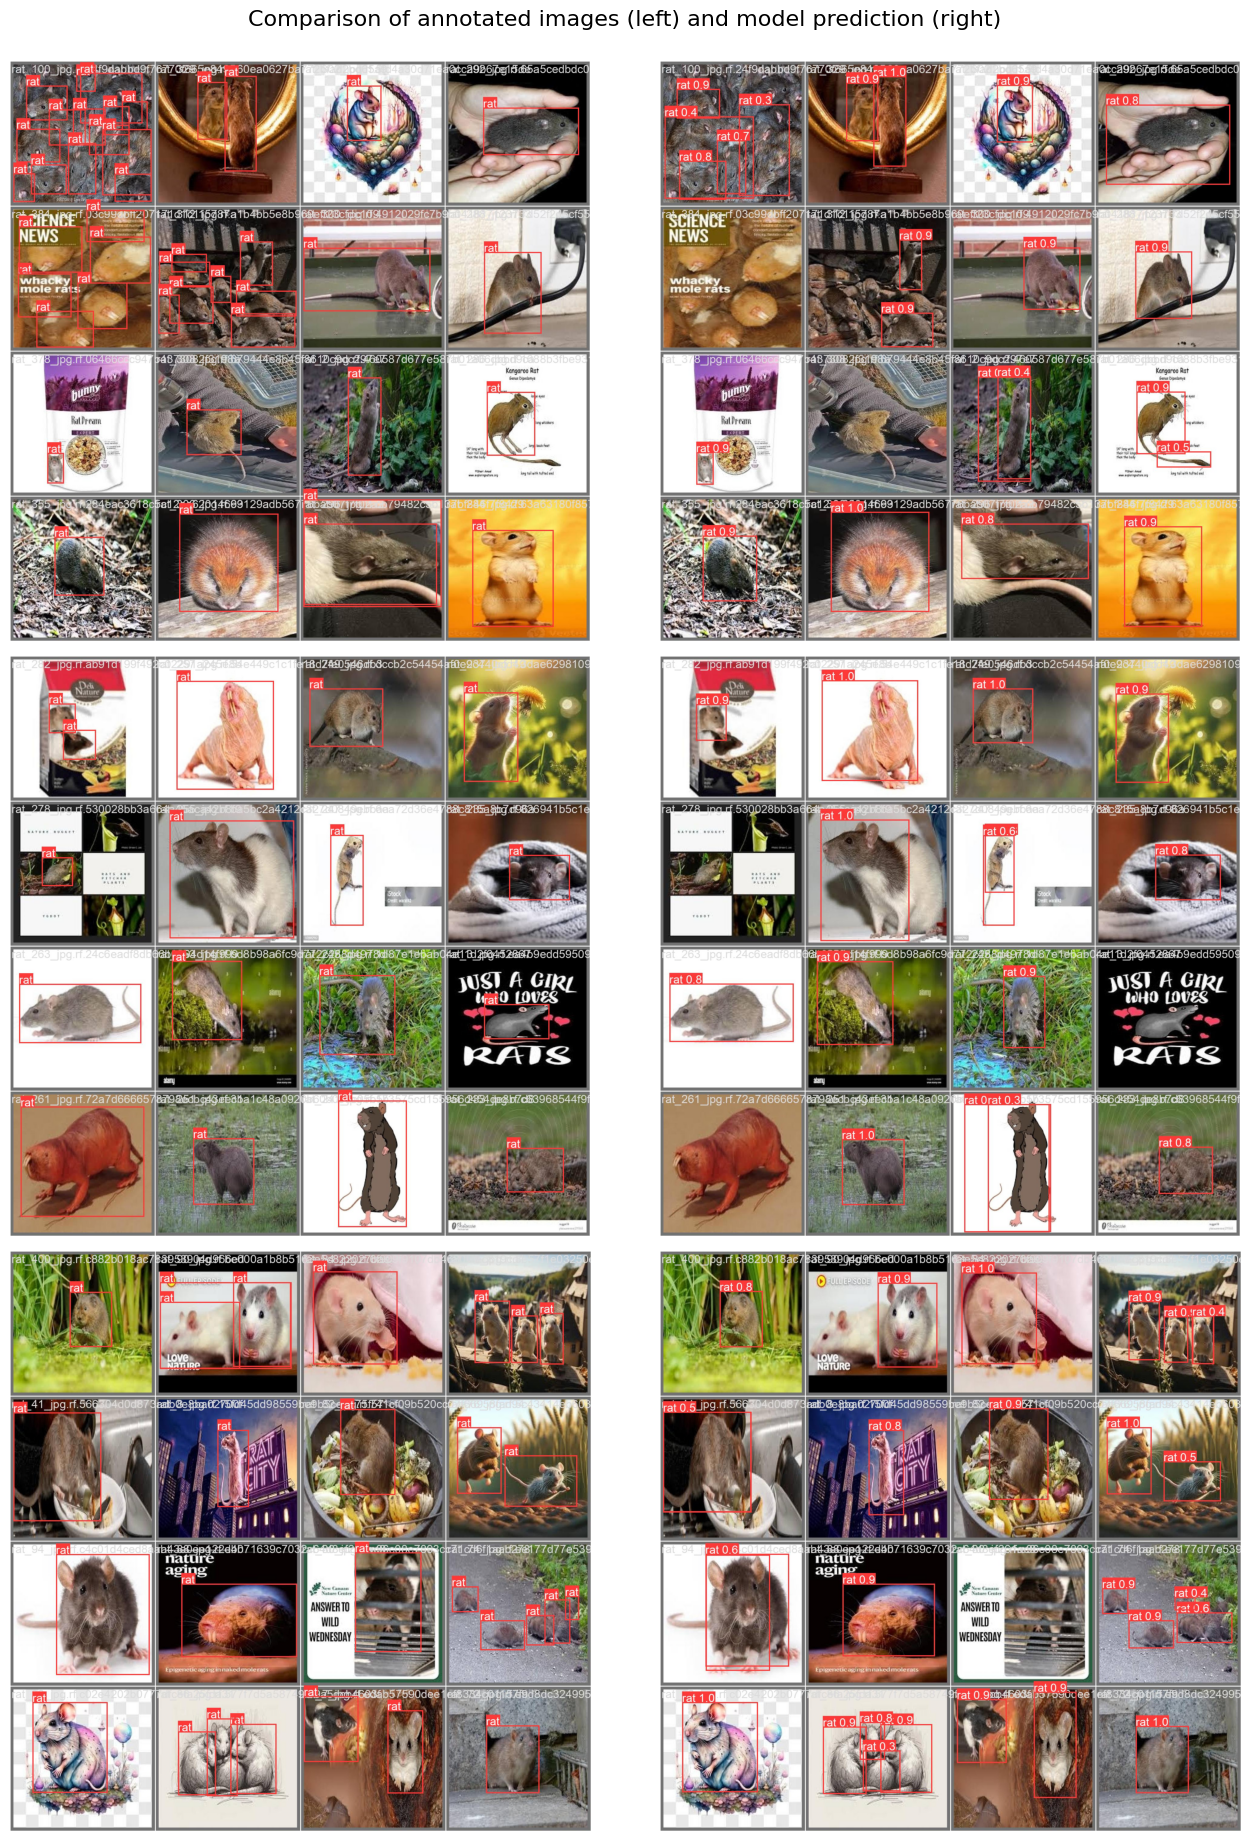

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_label0=mpimg.imread(f'{vpath}/val/val_batch0_labels.jpg')
img_pred0=mpimg.imread(f'{vpath}/val/val_batch0_pred.jpg')
img_label1=mpimg.imread(f'{vpath}/val/val_batch1_labels.jpg')
img_pred1=mpimg.imread(f'{vpath}/val/val_batch1_pred.jpg')
img_label2=mpimg.imread(f'{vpath}/val/val_batch2_labels.jpg')
img_pred2=mpimg.imread(f'{vpath}/val/val_batch2_pred.jpg')

fig, ax = plt.subplots(3, 2,figsize=(14,18))

ax[0,0].imshow(img_label0)
ax[0,1].imshow(img_pred0)


ax[1,0].imshow(img_label1)
ax[1,1].imshow(img_pred1)


ax[2,0].imshow(img_label2)
ax[2,1].imshow(img_pred2)

for a in fig.axes:
  a.axis('off')

plt.tight_layout()
fig.suptitle('Comparison of annotated images (left) and model prediction (right)',x=0.5,y=1.02,fontsize=16);

/content


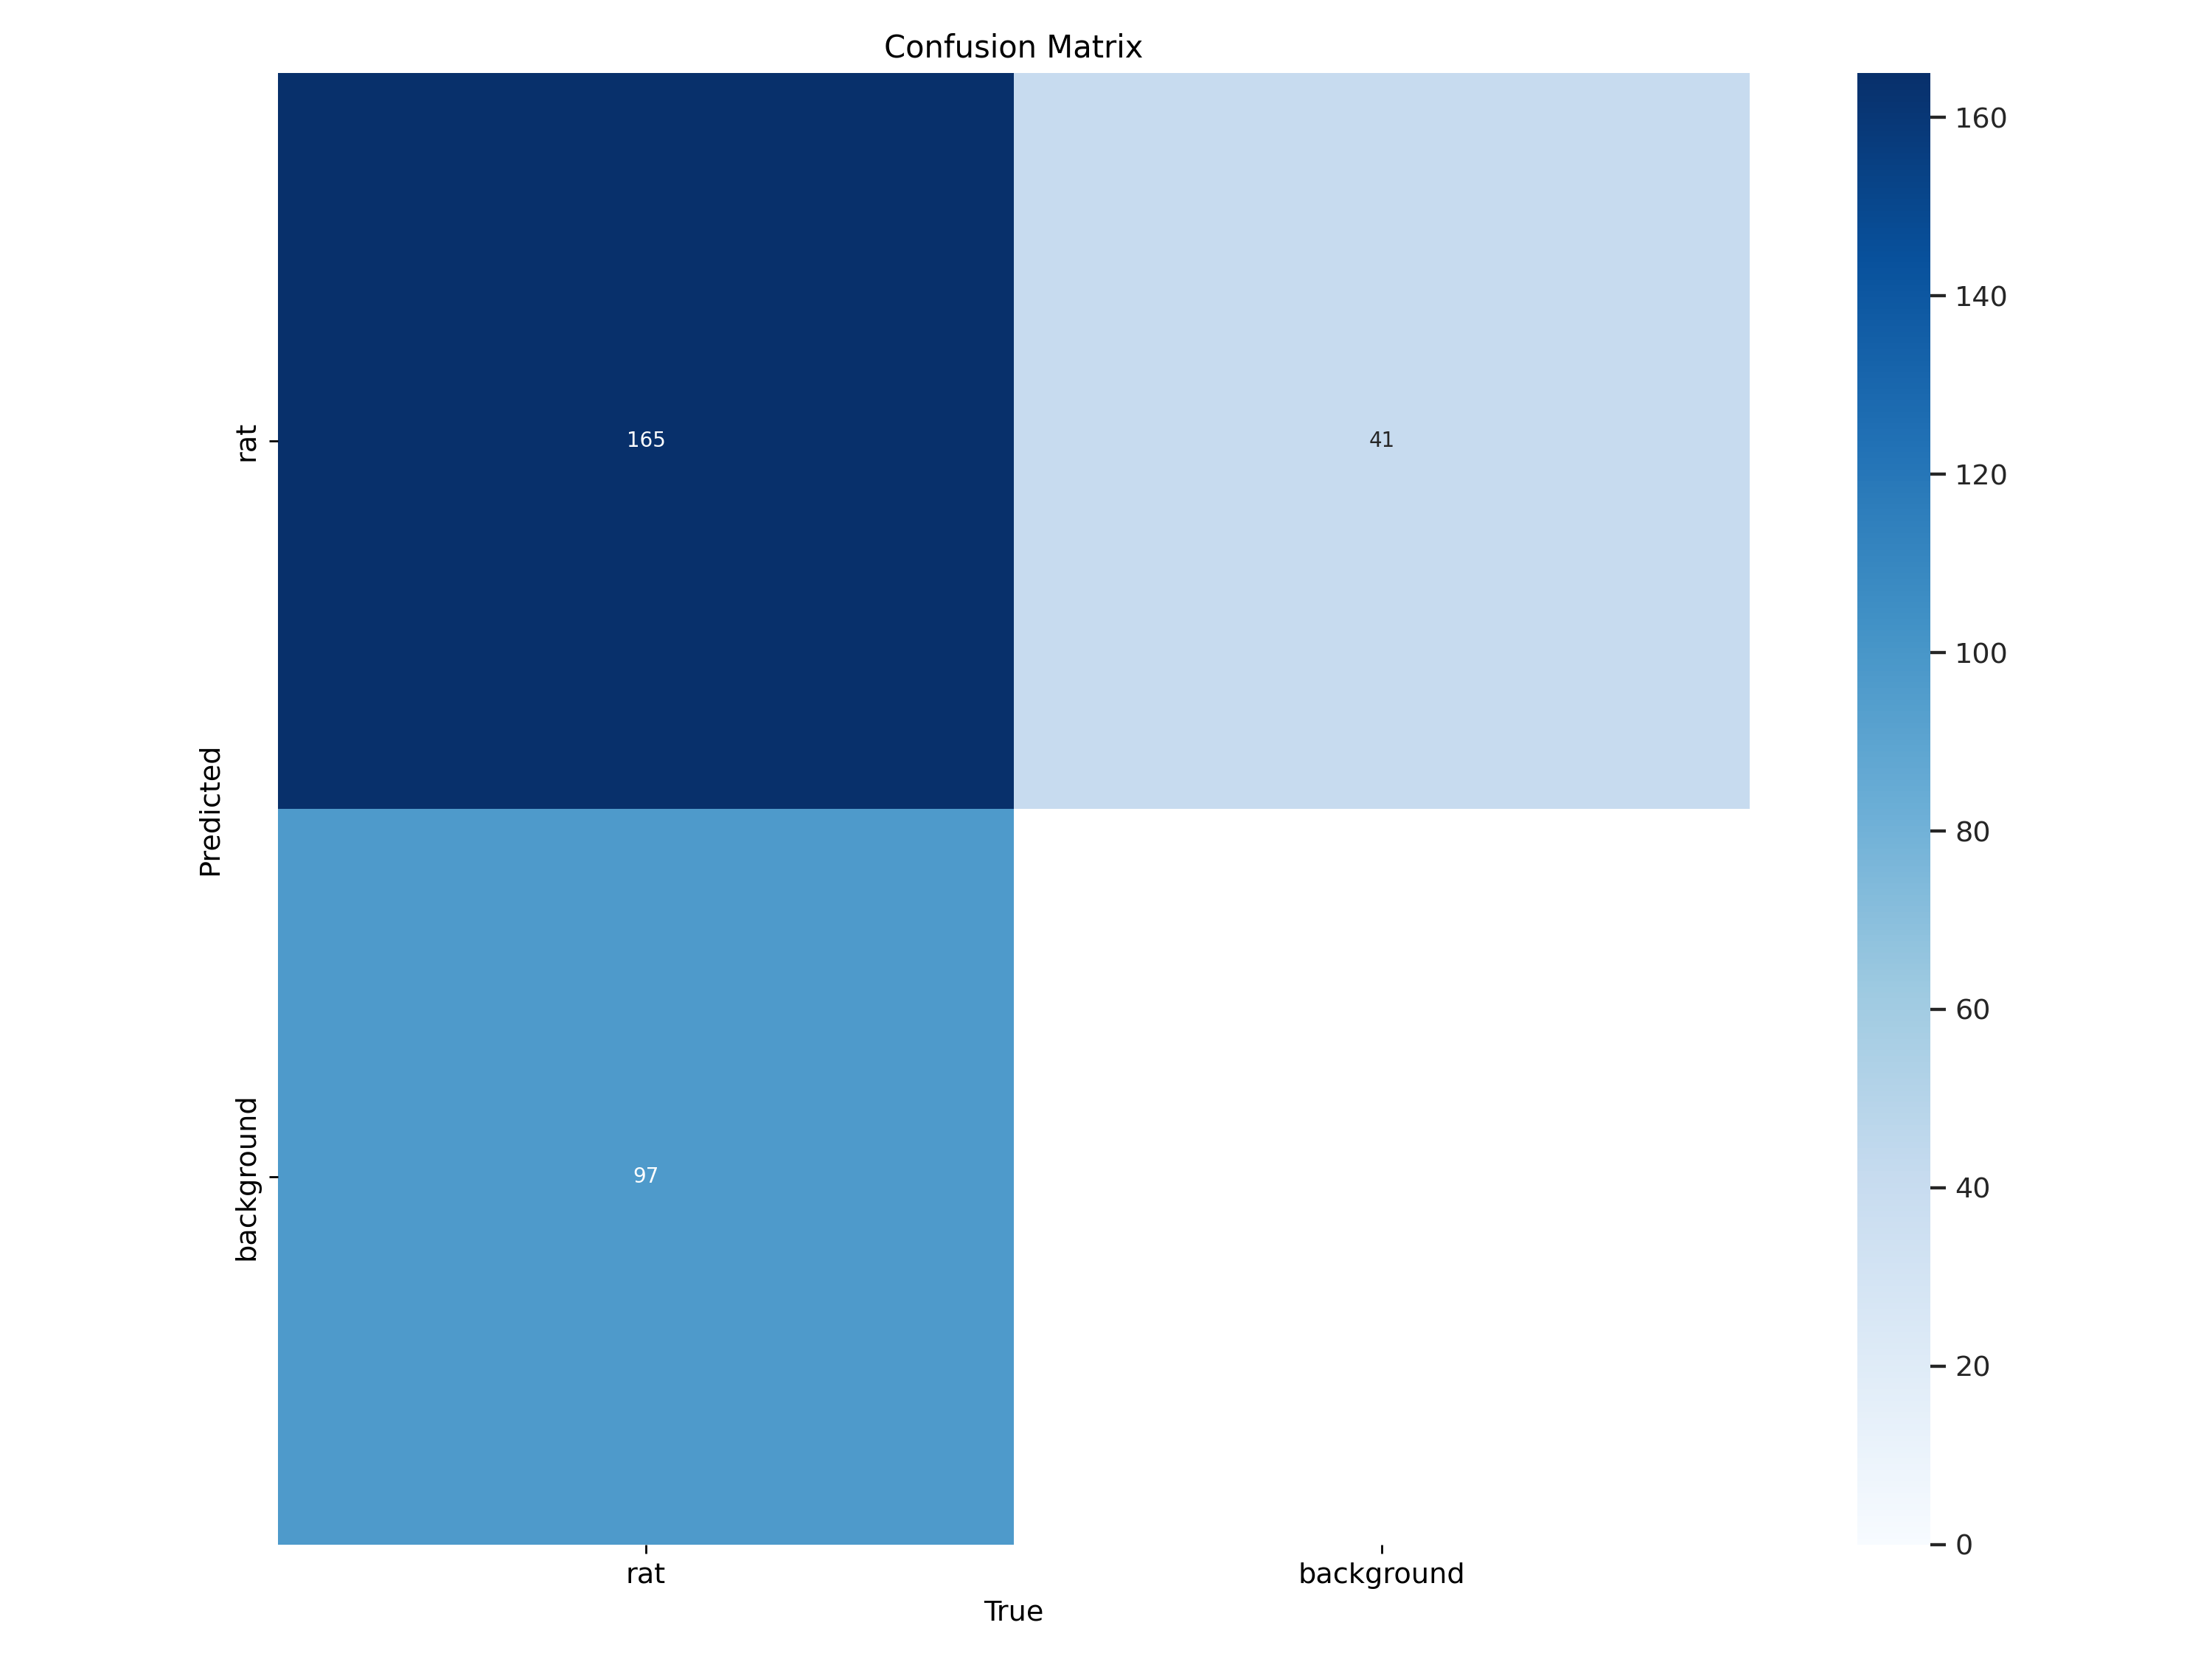

In [ ]:

from IPython.display import Image

%cd {HOME}
Image(filename=f'{vpath}/val/confusion_matrix.png', width=800)

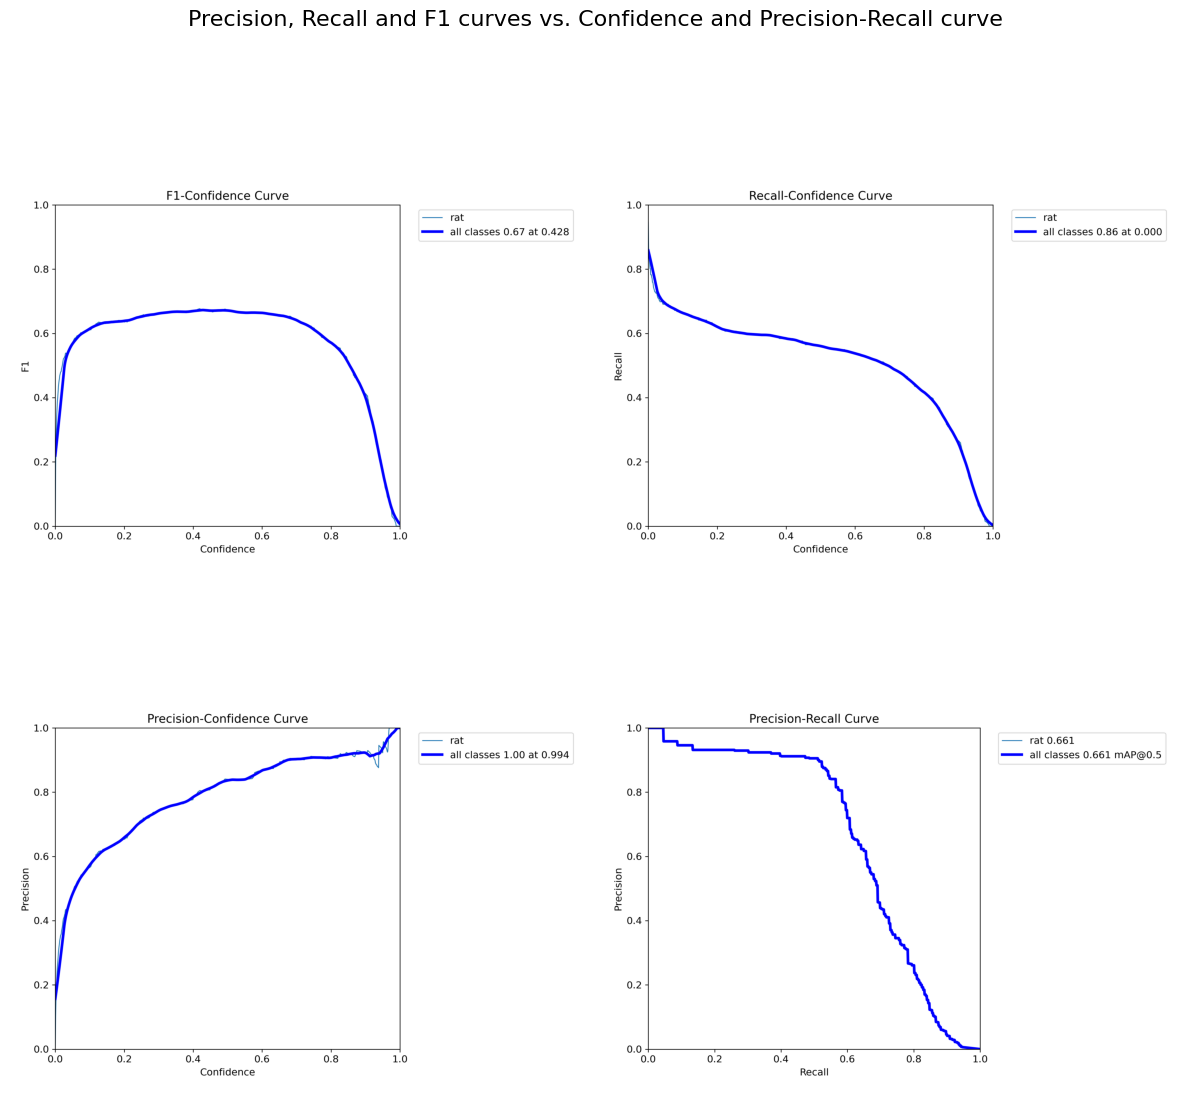

In [ ]:

# Average of Precision and Recall
# For more details see: https://docs.ultralytics.com/guides/yolo-performance-metrics/#introduction
# If it is most important not to miss rats Recall is a relevant measure
# If it is most important not to detect rats when there are none Precision is a relevant measure
# F1 is an aveage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_f1=mpimg.imread(f'{vpath}/val/F1_curve.png')
img_r=mpimg.imread(f'{vpath}/val/R_curve.png')
img_p=mpimg.imread(f'{vpath}/val/P_curve.png')
img_pr=mpimg.imread(f'{vpath}/val/PR_curve.png')


fig, ax = plt.subplots(2, 2,figsize=(12,12))

ax[0,0].imshow(img_f1)
ax[0,1].imshow(img_r)

ax[1,0].imshow(img_p)
ax[1,1].imshow(img_pr)

for a in fig.axes:
  a.axis('off')

plt.tight_layout()
fig.suptitle('Precision, Recall and F1 curves vs. Confidence and Precision-Recall curve',x=0.5,y=1.02,fontsize=16);


## Let's test the model

In [ ]:
from ultralytics import YOLOv10
import supervision as sv

model = YOLOv10(f'{vpath}/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

In [ ]:
# Run detection of 3 rat pictures from the internet

!yolo task=detect mode=predict conf=0.25 save=True \
model={vpath}/weights/best.pt exist_ok=True\
source={fpath}/Ratatouille.jpg

!yolo task=detect mode=predict conf=0.25 save=True \
model={vpath}/weights/best.pt exist_ok=True \
source={fpath}/rats_cage.jpg

!yolo task=detect mode=predict conf=0.25 save=True \
model={vpath}/weights/best.pt exist_ok=True \
source={fpath}/rat_street.jpg


Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/drive/MyDrive/Colabs/Rat_detector/Ratatouille.jpg: 640x576 1 rat, 353.6ms
Speed: 3.8ms preprocess, 353.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/drive/MyDrive/Colabs/Rat_detector/rats_cage.jpg: 384x640 7 rats, 139.3ms
Speed: 1.6ms preprocess, 139.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n 

/content


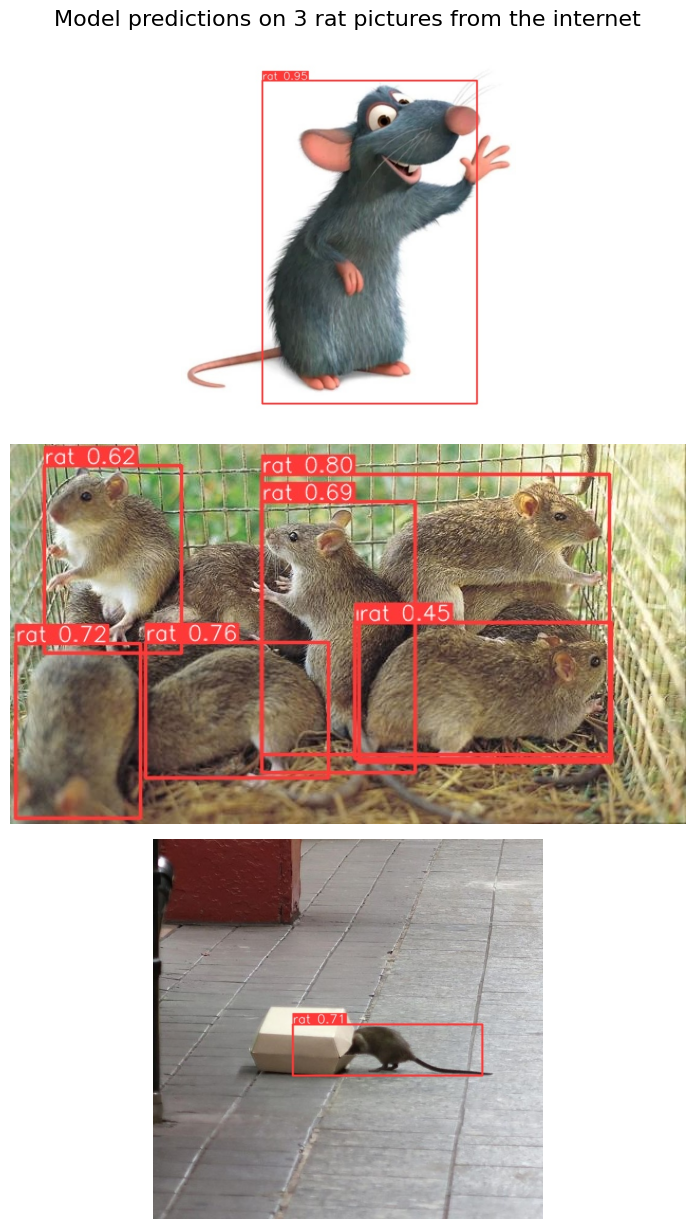

In [ ]:
%cd {HOME}

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Image(filename='runs/detect/predict/Ratatouille.jpg', height=600)
Image(filename='runs/detect/predict/rats_cage.jpg', height=600)
Image(filename='runs/detect/predict/rat_street.jpg', height=600)

img_1=mpimg.imread('runs/detect/predict/Ratatouille.jpg')
img_2=mpimg.imread('runs/detect/predict/rats_cage.jpg')
img_3=mpimg.imread('runs/detect/predict/rat_street.jpg')


fig, ax = plt.subplots(3, 1,figsize=(10,12))

ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)


for a in fig.axes:
  a.axis('off')

plt.tight_layout()
fig.suptitle('Model predictions on 3 rat pictures from the internet',x=0.5,y=1.02,fontsize=16);


Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/drive/MyDrive/Rat_detector/rats_cage.jpg: 384x640 7 rats, 172.4ms
Speed: 3.2ms preprocess, 172.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


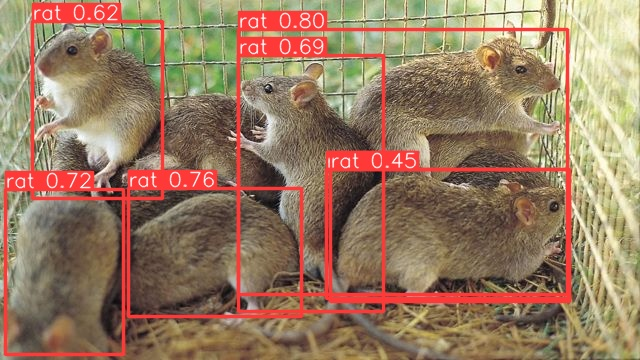

In [ ]:
%cd {HOME}

from IPython.display import Image


Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/drive/MyDrive/Rat_detector/rat_street.jpg: 640x640 1 rat, 265.9ms
Speed: 2.9ms preprocess, 265.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


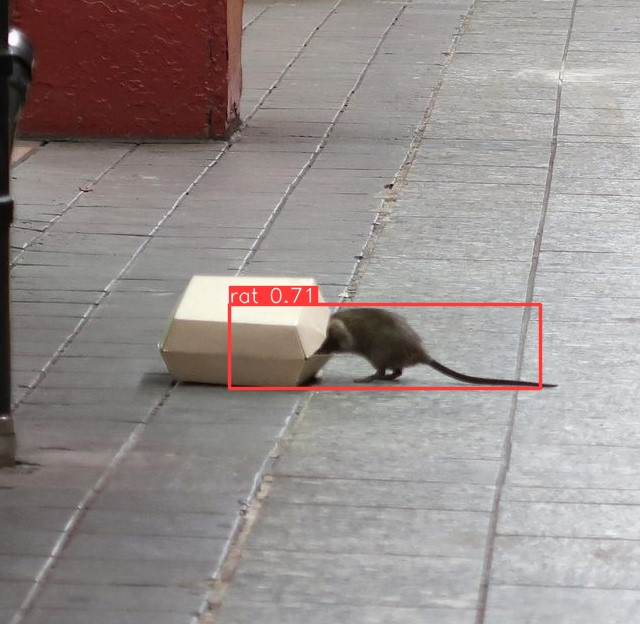

In [ ]:
%cd {HOME}

from IPython.display import Image


In [ ]:
ls -l runs/detect/predict

total 296
-rw-r--r-- 1 root root  60760 Jun 23 11:22 Ratatouille.jpg
-rw-r--r-- 1 root root 122095 Jun 23 11:22 rats_cage.jpg
-rw-r--r-- 1 root root 118593 Jun 23 11:23 rat_street.jpg


In [ ]:
!cp -r runs/detect/predict {rpath}/

In [ ]:
rpath

'/content/drive/MyDrive/Colabs/Rat_detector/train_v10n_freeze23'